In [21]:
using Pkg

In [22]:
Pkg.add("ScikitLearn")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("PyCall")
Pkg.add("PyPlot");
Pkg.add("MultivariateStats");

  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environ

In [23]:
using ScikitLearn
using DataFrames
using CSV
using PyCall
using PyPlot
using MultivariateStats

In [24]:
import ScikitLearn: CrossValidation

In [25]:
# @sk_import decomposition: PCA;
@sk_import preprocessing: MinMaxScaler;
@sk_import neighbors: KNeighborsClassifier;
@sk_import svm: LinearSVC;

In [26]:
np = pyimport("numpy");

In [68]:
df = CSV.File("01_hdp.csv"; header = true) |> DataFrame;

In [69]:
X_df = [df.tumorsize df.co2 df.lungcapacity df.Age df.WBC df.RBC df.BMI df.IL6 df.CRP df.Medicaid];

In [70]:
y_df = df.CancerStage;

In [71]:
X = convert(Array, X_df);
y = convert(Array, y_df);

## Normalizing the data and then splitting it into testing and training

In [72]:
mms = MinMaxScaler();
X_norm = mms.fit_transform(X);

In [73]:
X_train, X_test, y_train, y_test = CrossValidation.train_test_split(X_norm, y, test_size=0.30);

## Creating and fitting the PCA models with the training data. Then transforming the training and testing data with the trained model

In [74]:
pca_models = [];
X_train_pca = [];
X_test_pca = [];
test_times = [];
for i in 1:10
    time = @elapsed begin
    push!(pca_models, fit(KernelPCA, X_train'; maxoutdim=i));
    push!(X_test_pca, MultivariateStats.transform(pca_models[i], X_test'));
    end
    push!(test_times, time);
    push!(X_train_pca, MultivariateStats.transform(pca_models[i], X_train'));
end

## Determining the amount of components needed to maintain 90% explained variance

In [56]:
cumV = np.cumsum(pca_models[10].explained_variance_ratio_);
nComp = 0;
for i in 1:10
    if(cumV[i] > 0.9)
        nComp = i+1;
        break;
    end
end

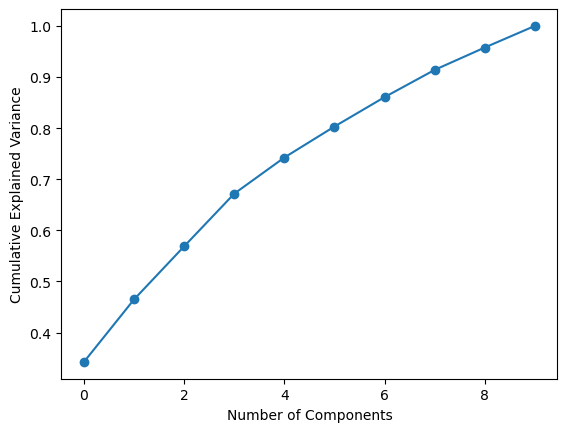

In [57]:
plt.plot(np.cumsum(pca_models[10].explained_variance_ratio_),"-o")
plt.xlabel("Number of Components");
plt.ylabel("Cumulative Explained Variance");

In [58]:
print("You need ", nComp, " principal components to preserve an explained varience of 90%");

You need 9 principal components to preserve an explained varience of 90%

## Using KNN as my classifier with the PCA data

In [62]:
neighbors = 450;
knn = KNeighborsClassifier(neighbors, metric="minkowski");
training_scores_knn = [];
testing_scores_knn = [];
for i in 1:10
    knn.fit(X_train_pca[i]', y_train);
    train_score = knn.score(X_train_pca[i]', y_train);
    test_score =  knn.score(X_test_pca[i]', y_test);
    println("Training accuracy with ", neighbors, " neighbors with ",i, " PCA component is: ", train_score);
    println("Testing accuracy with ", neighbors, " neighbors with ",i, " PCA component is: ", test_score);
    println();
    push!(training_scores_knn, train_score);
    push!(testing_scores_knn, test_score);
end

Training accuracy with 450 neighbors with 1 PCA component is: 0.40053628288922405
Testing accuracy with 450 neighbors with 1 PCA component is: 0.3983580922595778

Training accuracy with 450 neighbors with 2 PCA component is: 0.4018769901122842
Testing accuracy with 450 neighbors with 2 PCA component is: 0.39796716184519154

Training accuracy with 450 neighbors with 3 PCA component is: 0.4008714596949891
Testing accuracy with 450 neighbors with 3 PCA component is: 0.39757623143080534

Training accuracy with 450 neighbors with 4 PCA component is: 0.41980894922071393
Testing accuracy with 450 neighbors with 4 PCA component is: 0.4046129788897576

Training accuracy with 450 neighbors with 5 PCA component is: 0.41964136081783143
Testing accuracy with 450 neighbors with 5 PCA component is: 0.4030492572322127

Training accuracy with 450 neighbors with 6 PCA component is: 0.43908161555220376
Testing accuracy with 450 neighbors with 6 PCA component is: 0.41477716966379985

Training accuracy wit

In [55]:
svc = LinearSVC();
training_scores_svc = [];
testing_scores_svc = [];
for i in 1:10
    svc.fit(X_train_pca[i]', y_train);
    train_score = svc.score(X_train_pca[i]', y_train);
    test_score =  svc.score(X_test_pca[i]', y_test);
    println("Training accuracy with ",i, " PCA component is: ", train_score);
    println("Testing accuracy with ",i, " PCA component is: ", test_score);
    println();
    push!(training_scores_svc, train_score);
    push!(testing_scores_svc, test_score);
end

Training accuracy with 1 PCA component is: 0.40053628288922405
Testing accuracy with 1 PCA component is: 0.3983580922595778

Training accuracy with 2 PCA component is: 0.40053628288922405
Testing accuracy with 2 PCA component is: 0.3983580922595778

Training accuracy with 3 PCA component is: 0.40522875816993464
Testing accuracy with 3 PCA component is: 0.3971853010164191

Training accuracy with 4 PCA component is: 0.4188034188034188
Testing accuracy with 4 PCA component is: 0.4053948397185301

Training accuracy with 5 PCA component is: 0.4219875984581867
Testing accuracy with 5 PCA component is: 0.4065676309616888

Training accuracy with 6 PCA component is: 0.45081280375398025
Testing accuracy with 6 PCA component is: 0.4374511336982017

Training accuracy with 7 PCA component is: 0.45600804424333835
Testing accuracy with 7 PCA component is: 0.4311962470680219

Training accuracy with 8 PCA component is: 0.4580191050779286
Testing accuracy with 8 PCA component is: 0.4311962470680219

Tra

## Plotting the PCA components vs. accuracy for the training and testing data sets

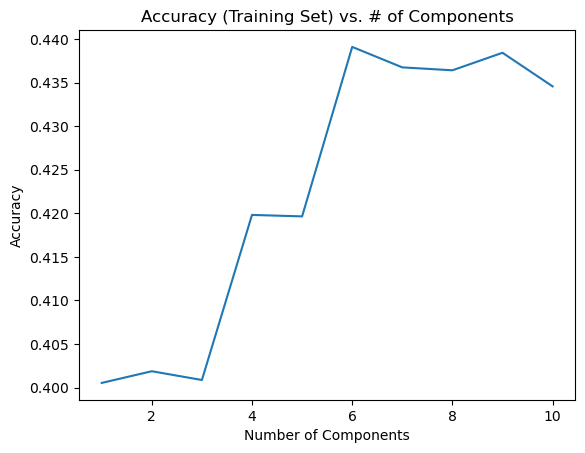

In [63]:
plt.plot(1:10, training_scores_knn);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Training Set) vs. # of Components");

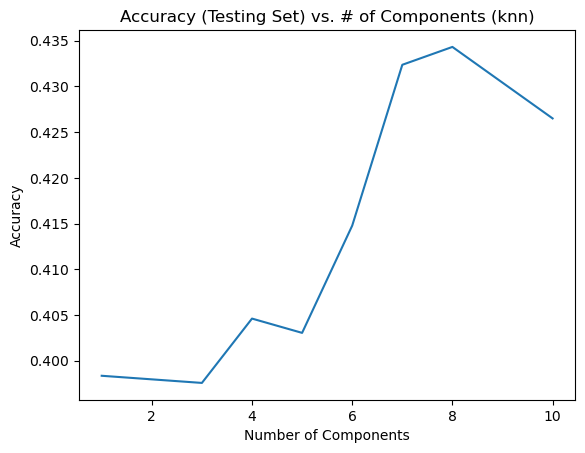

In [64]:
plt.plot(1:10, testing_scores_knn);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Testing Set) vs. # of Components (knn)");

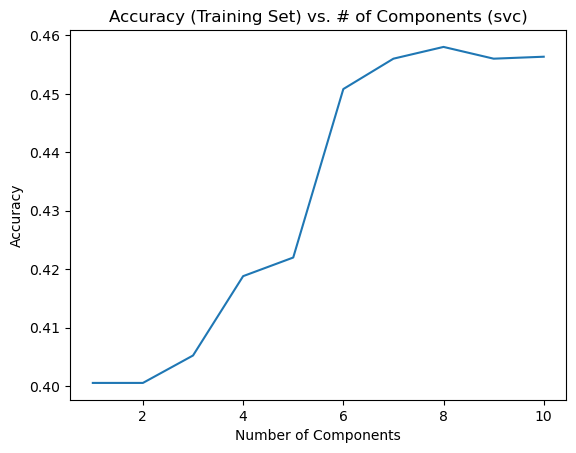

In [65]:
plt.plot(1:10, training_scores_svc);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Training Set) vs. # of Components (svc)");

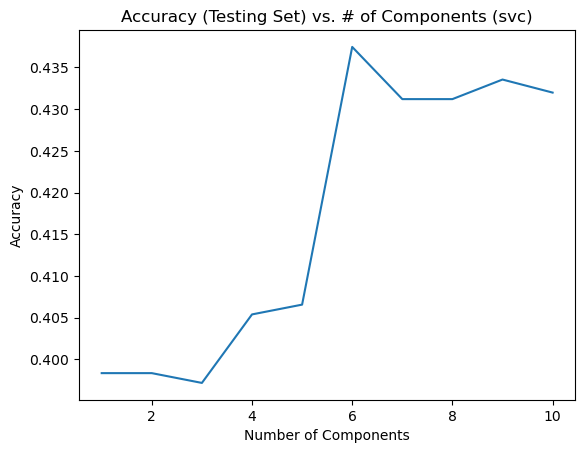

In [66]:
plt.plot(1:10, testing_scores_svc);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Testing Set) vs. # of Components (svc)");

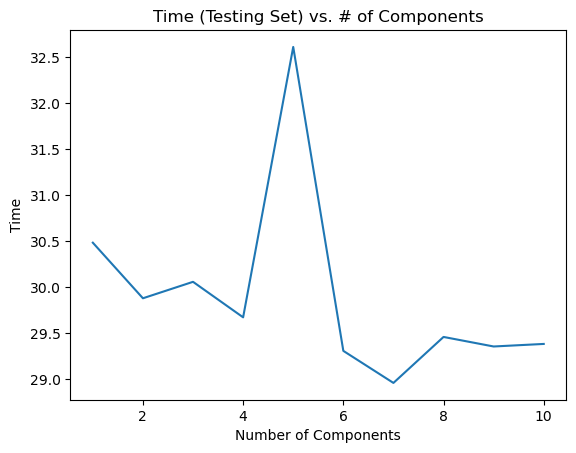

In [67]:
plt.plot(1:10, test_times);
plt.xlabel("Number of Components");
plt.ylabel("Time");
plt.title("Time (Testing Set) vs. # of Components");